# COMPAS Fairness Analysis: False Positive Rate Disparities Visualization

This notebook generates comprehensive visualizations of bias and fairness disparities in the COMPAS risk assessment tool using AI Fairness 360 (AIF360). The analysis focuses on false positive rates and other critical fairness metrics across demographic groups.

## 1. Import Required Libraries

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# AI Fairness 360 imports
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All libraries imported successfully!")
print("\nVersions:")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- matplotlib: {plt.matplotlib.__version__}")
print(f"- seaborn: {sns.__version__}")

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


✓ All libraries imported successfully!

Versions:
- pandas: 2.3.3
- numpy: 2.3.4
- matplotlib: 3.10.7
- seaborn: 0.13.2


## 2. Load COMPAS Dataset

In [2]:
# Load COMPAS Dataset
df = pd.read_csv('compas-scores-two-years.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nRace distribution:\n{df['race'].value_counts()}")

Dataset shape: (7214, 53)

Column names:
['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']

First few rows:
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel

## 3. Preprocess Data for Bias Analysis

In [4]:
# Preprocess Data for Bias Analysis
# Clean and prepare dataset
df_clean = df.copy()

# Remove rows with missing values in key columns
df_clean = df_clean.dropna(subset=['age', 'race', 'sex', 'decile_score', 'two_year_recid'])

# Create binary recidivism label (1 = recidivism, 0 = no recidivism)
df_clean['recidivism_label'] = df_clean['two_year_recid'].astype(int)

# Create binary prediction based on decile score (> 5 = high risk = 1)
df_clean['high_risk_prediction'] = (df_clean['decile_score'] > 5).astype(int)

# Encode race: African-American = 1 (protected/unprivileged), Others = 0
df_clean['race_encoded'] = (df_clean['race'] == 'African-American').astype(int)

# Create binary gender: Male = 1, Female = 0
df_clean['gender_encoded'] = (df_clean['sex'] == 'Male').astype(int)

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"\nRecidivism label distribution:\n{df_clean['recidivism_label'].value_counts()}")
print(f"\nHigh-risk prediction distribution:\n{df_clean['high_risk_prediction'].value_counts()}")
print(f"\nRace distribution (0=Other, 1=AA):\n{df_clean['race_encoded'].value_counts()}")
print(f"\nSample of processed data:")
print(df_clean[['age', 'race', 'race_encoded', 'high_risk_prediction', 'recidivism_label']].head(10))

Cleaned dataset shape: (7214, 57)

Recidivism label distribution:
recidivism_label
0    3963
1    3251
Name: count, dtype: int64

High-risk prediction distribution:
high_risk_prediction
0    4578
1    2636
Name: count, dtype: int64

Race distribution (0=Other, 1=AA):
race_encoded
1    3696
0    3518
Name: count, dtype: int64

Sample of processed data:
   age              race  race_encoded  high_risk_prediction  recidivism_label
0   69             Other             0                     0                 0
1   34  African-American             1                     0                 1
2   24  African-American             1                     0                 1
3   23  African-American             1                     1                 0
4   43             Other             0                     0                 0
5   44             Other             0                     0                 0
6   41         Caucasian             0                     1                 1
7   43        

## 4. Compute False Positive Rates and Error Metrics by Group

In [5]:
# Compute error metrics by race
def calculate_error_metrics(data, group_col, pred_col, label_col):
    """Calculate FPR, FNR, TPR, TNR for each group"""
    groups = data[group_col].unique()
    metrics = {}
    
    for group in groups:
        group_data = data[data[group_col] == group]
        y_true = group_data[label_col].values
        y_pred = group_data[pred_col].values
        
        # Confusion matrix elements
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tp = np.sum((y_pred == 1) & (y_true == 1))
        
        # Calculate rates
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        metrics[group] = {
            'FPR': fpr,
            'FNR': fnr,
            'TPR': tpr,
            'TNR': tnr,
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn,
            'Total': len(group_data)
        }
    
    return metrics

# Calculate metrics by race
race_metrics = calculate_error_metrics(df_clean, 'race_encoded', 'high_risk_prediction', 'recidivism_label')

# Calculate metrics by gender
gender_metrics = calculate_error_metrics(df_clean, 'gender_encoded', 'high_risk_prediction', 'recidivism_label')

# Display results
print("=" * 60)
print("ERROR METRICS BY RACE (0=Other, 1=African-American)")
print("=" * 60)
for group, metrics in race_metrics.items():
    group_name = "African-American" if group == 1 else "Other Races"
    print(f"\n{group_name}:")
    print(f"  False Positive Rate (FPR): {metrics['FPR']:.4f} ({metrics['FPR']*100:.2f}%)")
    print(f"  False Negative Rate (FNR): {metrics['FNR']:.4f} ({metrics['FNR']*100:.2f}%)")
    print(f"  True Positive Rate (TPR):  {metrics['TPR']:.4f} ({metrics['TPR']*100:.2f}%)")
    print(f"  True Negative Rate (TNR):  {metrics['TNR']:.4f} ({metrics['TNR']*100:.2f}%)")
    print(f"  Confusion Matrix: TP={metrics['TP']}, FP={metrics['FP']}, TN={metrics['TN']}, FN={metrics['FN']}")
    print(f"  Total samples: {metrics['Total']}")

print("\n" + "=" * 60)
print("FPR DISPARITY (Fairness Analysis)")
print("=" * 60)
fpr_aa = race_metrics[1]['FPR']
fpr_other = race_metrics[0]['FPR']
fpr_ratio = fpr_aa / fpr_other if fpr_other != 0 else np.inf
fpr_difference = fpr_aa - fpr_other

print(f"FPR for African-Americans: {fpr_aa:.4f}")
print(f"FPR for Other Races:       {fpr_other:.4f}")
print(f"FPR Ratio (AA/Other):      {fpr_ratio:.4f}")
print(f"FPR Difference:            {fpr_difference:.4f}")
print(f"\n✓ If FPR ratio > 1.25: Significant disparity detected!")
print(f"✓ Current ratio: {'⚠️ DISPARITY DETECTED' if fpr_ratio > 1.25 else '✓ Acceptable'}")

ERROR METRICS BY RACE (0=Other, 1=African-American)

Other Races:
  False Positive Rate (FPR): 0.1435 (14.35%)
  False Negative Rate (FNR): 0.6178 (61.78%)
  True Positive Rate (TPR):  0.3822 (38.22%)
  True Negative Rate (TNR):  0.8565 (85.65%)
  Confusion Matrix: TP=516, FP=311, TN=1857, FN=834
  Total samples: 3518

African-American:
  False Positive Rate (FPR): 0.3432 (34.32%)
  False Negative Rate (FNR): 0.3724 (37.24%)
  True Positive Rate (TPR):  0.6276 (62.76%)
  True Negative Rate (TNR):  0.6568 (65.68%)
  Confusion Matrix: TP=1193, FP=616, TN=1179, FN=708
  Total samples: 3696

FPR DISPARITY (Fairness Analysis)
FPR for African-Americans: 0.3432
FPR for Other Races:       0.1435
FPR Ratio (AA/Other):      2.3923
FPR Difference:            0.1997

✓ If FPR ratio > 1.25: Significant disparity detected!
✓ Current ratio: ⚠️ DISPARITY DETECTED


## 5. Visualize Disparity in False Positive Rates

✓ Visualization saved: 01_FPR_Disparity_Analysis.png


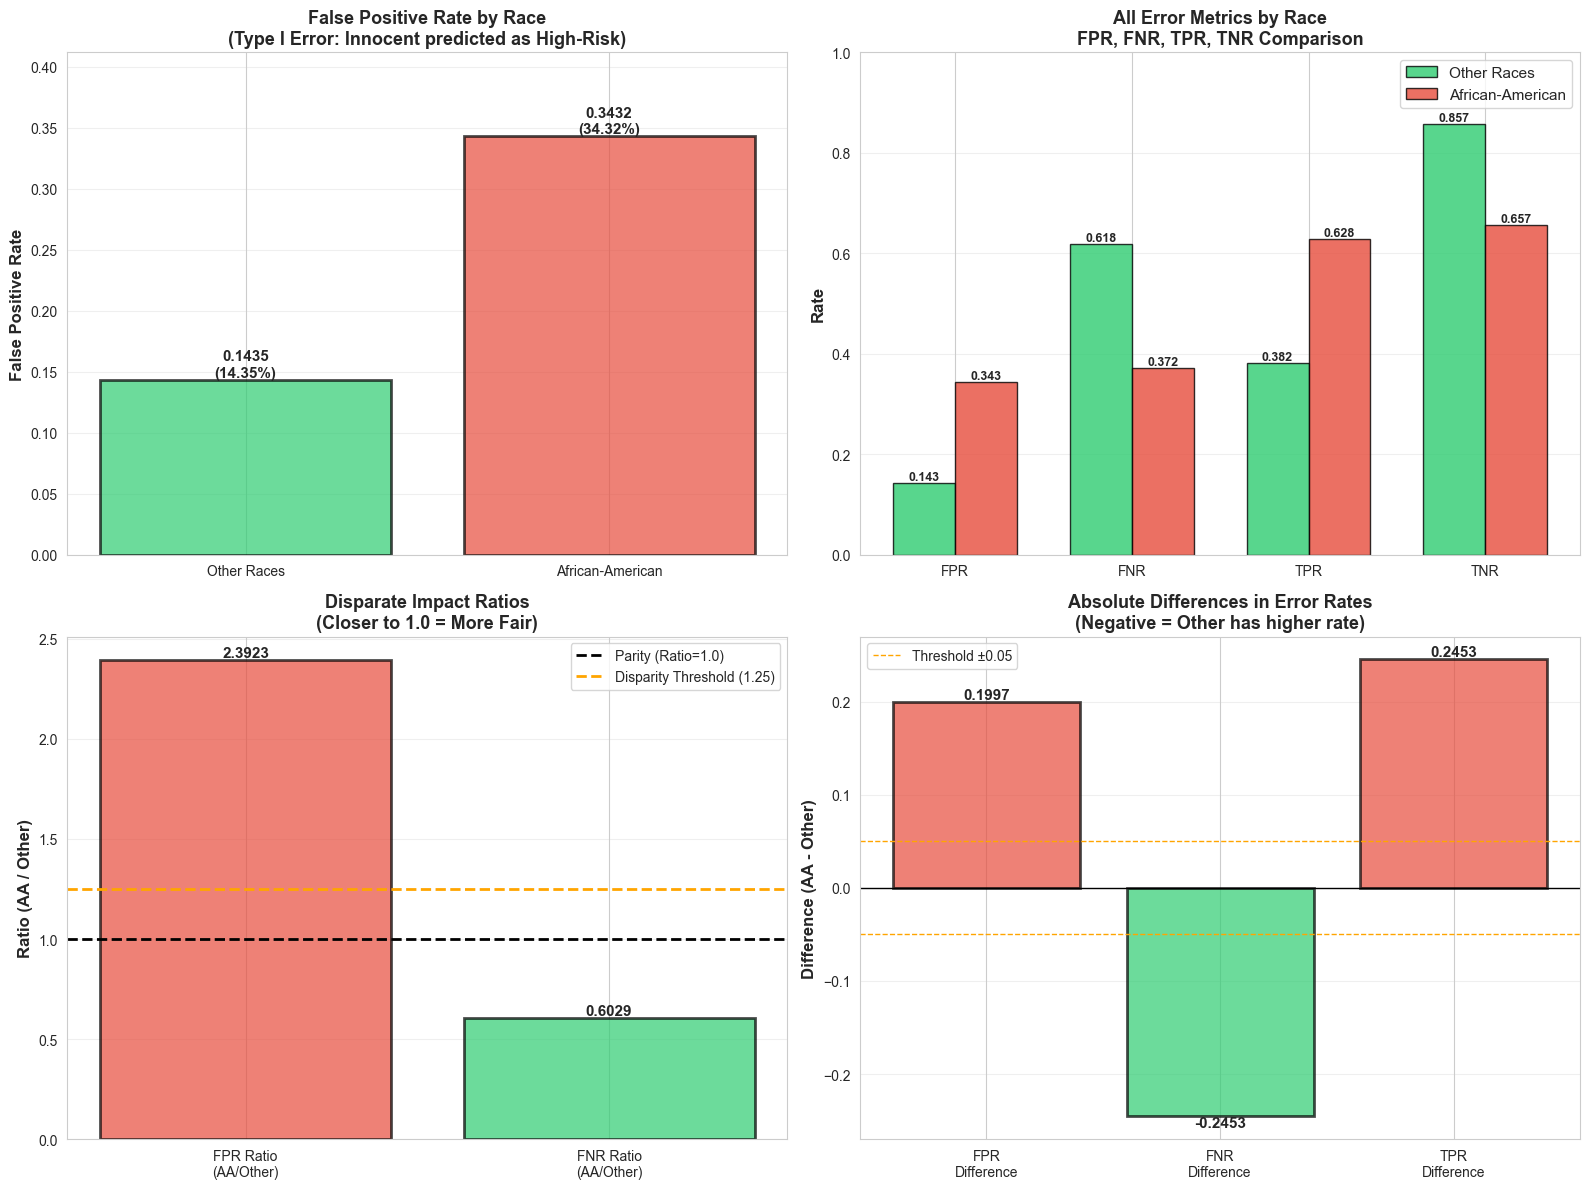

In [6]:
# Visualization 1: False Positive Rate Comparison by Race
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: FPR Comparison
groups = ['Other Races', 'African-American']
fpr_values = [race_metrics[0]['FPR'], race_metrics[1]['FPR']]
colors = ['#2ecc71', '#e74c3c']

ax = axes[0, 0]
bars = ax.bar(groups, fpr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('False Positive Rate by Race\n(Type I Error: Innocent predicted as High-Risk)', 
             fontsize=13, fontweight='bold')
ax.set_ylim(0, max(fpr_values) * 1.2)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, fpr_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}\n({val*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Error Rate Comparison (All Rates)
ax = axes[0, 1]
metrics_names = ['FPR', 'FNR', 'TPR', 'TNR']
aa_rates = [race_metrics[1][m] for m in metrics_names]
other_rates = [race_metrics[0][m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, other_rates, width, label='Other Races', alpha=0.8, color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, aa_rates, width, label='African-American', alpha=0.8, color='#e74c3c', edgecolor='black')

ax.set_ylabel('Rate', fontsize=12, fontweight='bold')
ax.set_title('All Error Metrics by Race\nFPR, FNR, TPR, TNR Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Disparity Ratio
ax = axes[1, 0]
fpr_ratio = fpr_aa / fpr_other if fpr_other != 0 else 0
fnr_aa = race_metrics[1]['FNR']
fnr_other = race_metrics[0]['FNR']
fnr_ratio = fnr_aa / fnr_other if fnr_other != 0 else 0

disparity_ratios = [fpr_ratio, fnr_ratio]
ratio_labels = ['FPR Ratio\n(AA/Other)', 'FNR Ratio\n(AA/Other)']
colors_ratio = ['#e74c3c' if r > 1.1 else '#2ecc71' for r in disparity_ratios]

bars = ax.bar(ratio_labels, disparity_ratios, color=colors_ratio, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Parity (Ratio=1.0)')
ax.axhline(y=1.25, color='orange', linestyle='--', linewidth=2, label='Disparity Threshold (1.25)')
ax.set_ylabel('Ratio (AA / Other)', fontsize=12, fontweight='bold')
ax.set_title('Disparate Impact Ratios\n(Closer to 1.0 = More Fair)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, disparity_ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 4: Absolute Differences
ax = axes[1, 1]
fpr_diff = fpr_aa - fpr_other
fnr_diff = fnr_aa - fnr_other
tpr_aa = race_metrics[1]['TPR']
tpr_other = race_metrics[0]['TPR']
tpr_diff = tpr_aa - tpr_other

diffs = [fpr_diff, fnr_diff, tpr_diff]
diff_labels = ['FPR\nDifference', 'FNR\nDifference', 'TPR\nDifference']
colors_diff = ['#e74c3c' if d > 0.05 else '#2ecc71' for d in diffs]

bars = ax.bar(diff_labels, diffs, color=colors_diff, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='Threshold ±0.05')
ax.axhline(y=-0.05, color='orange', linestyle='--', linewidth=1)
ax.set_ylabel('Difference (AA - Other)', fontsize=12, fontweight='bold')
ax.set_title('Absolute Differences in Error Rates\n(Negative = Other has higher rate)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, diffs):
    height = bar.get_height()
    y_pos = height if height >= 0 else height
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{val:.4f}', ha='center', va='bottom' if height >= 0 else 'top', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('01_FPR_Disparity_Analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: 01_FPR_Disparity_Analysis.png")
plt.show()

✓ Visualization saved: 02_Confusion_Matrices_by_Race.png


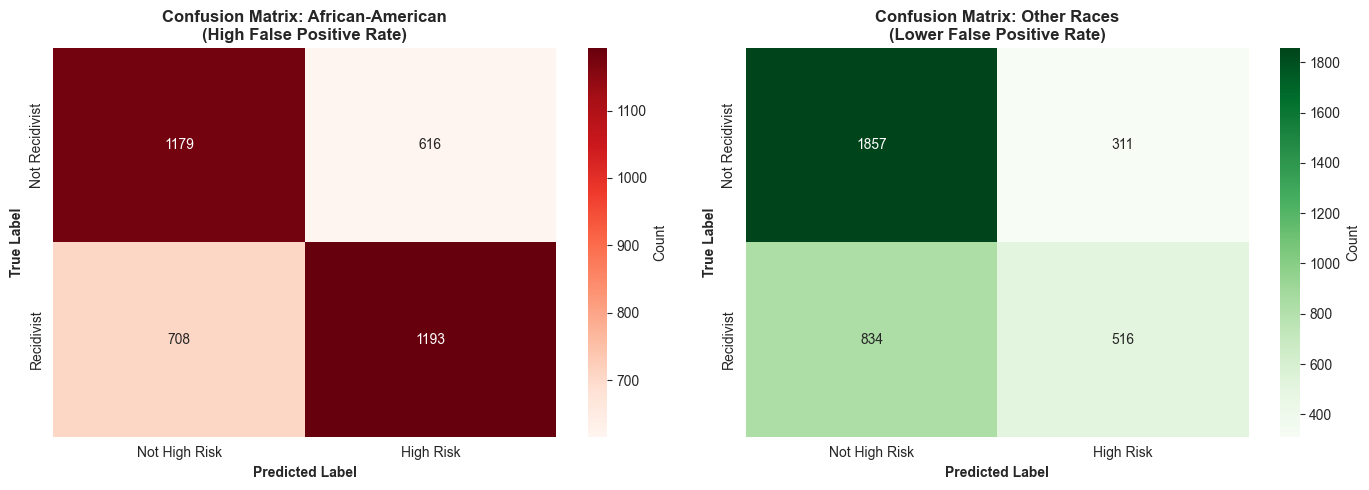

In [7]:
# Visualization 2: Confusion Matrices Heatmap by Race
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# African-American Confusion Matrix
cm_aa = np.array([
    [race_metrics[1]['TN'], race_metrics[1]['FP']],
    [race_metrics[1]['FN'], race_metrics[1]['TP']]
])

# Other Races Confusion Matrix
cm_other = np.array([
    [race_metrics[0]['TN'], race_metrics[0]['FP']],
    [race_metrics[0]['FN'], race_metrics[0]['TP']]
])

# Plot African-American CM
sns.heatmap(cm_aa, annot=True, fmt='d', cmap='Reds', ax=axes[0], 
            xticklabels=['Not High Risk', 'High Risk'],
            yticklabels=['Not Recidivist', 'Recidivist'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix: African-American\n(High False Positive Rate)', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Plot Other Races CM
sns.heatmap(cm_other, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not High Risk', 'High Risk'],
            yticklabels=['Not Recidivist', 'Recidivist'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix: Other Races\n(Lower False Positive Rate)', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('02_Confusion_Matrices_by_Race.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: 02_Confusion_Matrices_by_Race.png")
plt.show()

## 6. Use AI Fairness 360 Metrics for Comprehensive Bias Evaluation

In [11]:
# Create AIF360 BinaryLabelDataset for fairness metrics
# Prepare data in AIF360 format - with both labels and predictions
df_aif = df_clean[['age', 'race_encoded', 'gender_encoded', 'recidivism_label']].copy()
df_aif.columns = ['age', 'race', 'gender', 'label']

# Create BinaryLabelDataset with proper API
favorable_label = 0  # Not recidivist (favorable outcome)
unfavorable_label = 1  # Recidivist (unfavorable outcome)

aif_dataset = BinaryLabelDataset(
    df=df_aif,
    label_names=['label'],
    protected_attribute_names=['race'],
    favorable_label=favorable_label,
    unfavorable_label=unfavorable_label
)

# Create dataset with predictions by copying and replacing labels with predictions
df_aif_pred = df_aif.copy()
df_aif_pred['label'] = df_clean['high_risk_prediction'].values  # Use predictions as labels

aif_dataset_pred = BinaryLabelDataset(
    df=df_aif_pred,
    label_names=['label'],
    protected_attribute_names=['race'],
    favorable_label=0,  # Not high-risk is favorable
    unfavorable_label=1
)

# Calculate AIF360 metrics
print("=" * 70)
print("AI FAIRNESS 360 BIAS METRICS")
print("=" * 70)

# Dataset metric (pre-decision - actual labels)
dataset_metric = BinaryLabelDatasetMetric(
    aif_dataset,
    unprivileged_groups=[{'race': 1}],  # African-American
    privileged_groups=[{'race': 0}]      # Other Races
)

print("\n📊 DATASET-LEVEL METRICS (Ground Truth Distribution):")
print("-" * 70)
print(f"Disparate Impact Ratio: {dataset_metric.disparate_impact():.4f}")
print(f"Statistical Parity Difference: {dataset_metric.statistical_parity_difference():.4f}")

# Classification metric (post-decision/predictions)
class_metric = ClassificationMetric(
    aif_dataset,
    aif_dataset_pred,
    unprivileged_groups=[{'race': 1}],
    privileged_groups=[{'race': 0}]
)

print("\n📊 CLASSIFICATION METRICS (Predictions):")
print("-" * 70)
print(f"False Positive Rate Difference: {class_metric.false_positive_rate_difference():.4f}")
print(f"  African-American FPR - Other Races FPR")
print(f"  (Negative value means AA has higher FPR)")

print(f"\nFalse Negative Rate Difference: {class_metric.false_negative_rate_difference():.4f}")
print(f"  African-American FNR - Other Races FNR")

print(f"\nEqual Opportunity Difference: {class_metric.equal_opportunity_difference():.4f}")
print(f"  (Difference in True Positive Rates)")

print(f"\nAverage Odds Difference: {class_metric.average_odds_difference():.4f}")
print(f"  (Average of FPR and FNR differences)")

print(f"\nGeneralized Entropy Index: {class_metric.generalized_entropy_index():.4f}")
print(f"  (Measure of overall inequality)")

print(f"\nTheil Index: {class_metric.theil_index():.4f}")
print(f"  (Alternative inequality measure)")

print("\n" + "=" * 70)
print("METRIC INTERPRETATION:")
print("=" * 70)
print("✓ Value close to 0 = Fair/Equitable")
print("✓ Value far from 0 = Biased")
print("✓ Negative value = African-American group disadvantaged")
print("=" * 70)

AI FAIRNESS 360 BIAS METRICS

📊 DATASET-LEVEL METRICS (Ground Truth Distribution):
----------------------------------------------------------------------
Disparate Impact Ratio: 0.7881
Statistical Parity Difference: -0.1306

📊 CLASSIFICATION METRICS (Predictions):
----------------------------------------------------------------------
False Positive Rate Difference: -0.2453
  African-American FPR - Other Races FPR
  (Negative value means AA has higher FPR)

False Negative Rate Difference: 0.1997
  African-American FNR - Other Races FNR

Equal Opportunity Difference: -0.1997
  (Difference in True Positive Rates)

Average Odds Difference: -0.2225
  (Average of FPR and FNR differences)

Generalized Entropy Index: 0.1422
  (Measure of overall inequality)

Theil Index: 0.1912
  (Alternative inequality measure)

METRIC INTERPRETATION:
✓ Value close to 0 = Fair/Equitable
✓ Value far from 0 = Biased
✓ Negative value = African-American group disadvantaged


## 7. Visualize Additional Fairness Metrics

✓ Visualization saved: 03_AIF360_Fairness_Metrics.png


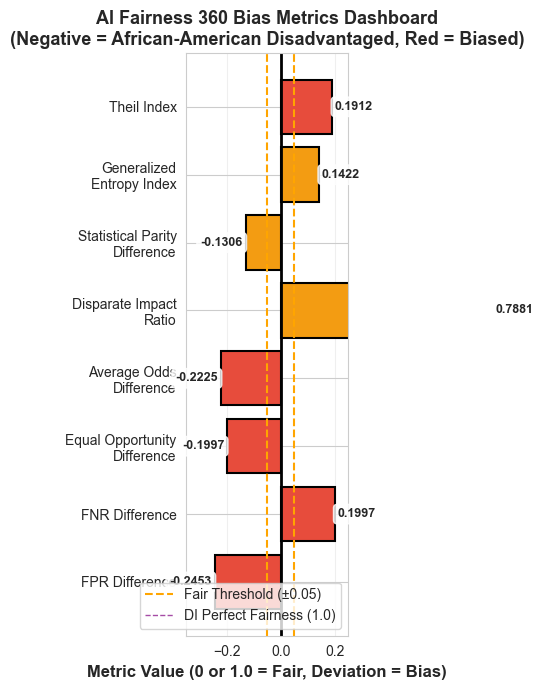

In [13]:
# Visualization 3: Comprehensive Fairness Metrics Heatmap
fig, ax = plt.subplots(figsize=(12, 7))

# Collect all AIF360 metrics
metrics_dict = {
    'FPR Difference': class_metric.false_positive_rate_difference(),
    'FNR Difference': class_metric.false_negative_rate_difference(),
    'Equal Opportunity\nDifference': class_metric.equal_opportunity_difference(),
    'Average Odds\nDifference': class_metric.average_odds_difference(),
    'Disparate Impact\nRatio': dataset_metric.disparate_impact(),
    'Statistical Parity\nDifference': dataset_metric.statistical_parity_difference(),
    'Generalized\nEntropy Index': class_metric.generalized_entropy_index(),
    'Theil Index': class_metric.theil_index()
}

# Prepare data for visualization
metric_names = list(metrics_dict.keys())
metric_values = list(metrics_dict.values())

# Normalize values for better visualization (heatmap style)
# Use diverging colormap: negative=red (unfair), 0=white (fair), positive=green
metric_values_normalized = metric_values

# Create horizontal bar chart with color coding
colors = []
for val in metric_values:
    # For DI Ratio, values closer to 1.0 are fair
    if 'Disparate Impact' in str(metric_names[metric_values.index(val)]):
        if abs(val - 1.0) < 0.1:
            colors.append('#2ecc71')  # Green - Fair
        elif abs(val - 1.0) < 0.25:
            colors.append('#f39c12')  # Orange - Moderate Disparity
        else:
            colors.append('#e74c3c')  # Red - High Disparity
    else:
        # For other metrics, closer to 0 is fair
        if abs(val) < 0.05:
            colors.append('#2ecc71')  # Green - Fair
        elif abs(val) < 0.15:
            colors.append('#f39c12')  # Orange - Moderate Disparity
        else:
            colors.append('#e74c3c')  # Red - High Disparity

bars = ax.barh(metric_names, metric_values, color=colors, edgecolor='black', linewidth=1.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.axvline(x=0.05, color='orange', linestyle='--', linewidth=1.5, label='Fair Threshold (±0.05)')
ax.axvline(x=-0.05, color='orange', linestyle='--', linewidth=1.5)
ax.axvline(x=1.0, color='purple', linestyle='--', linewidth=1, alpha=0.7, label='DI Perfect Fairness (1.0)')

ax.set_xlabel('Metric Value (0 or 1.0 = Fair, Deviation = Bias)', fontsize=12, fontweight='bold')
ax.set_title('AI Fairness 360 Bias Metrics Dashboard\n(Negative = African-American Disadvantaged, Red = Biased)', 
             fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(-0.35, 0.25)

# Add value labels
for bar, val in zip(bars, metric_values):
    width = bar.get_width()
    x_pos = width + 0.01 if width > 0 else width - 0.01
    ax.text(x_pos, bar.get_y() + bar.get_height()/2.,
            f'{val:.4f}', ha='left' if width > 0 else 'right', va='center',
            fontsize=9, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.legend(fontsize=10, loc='lower right')
plt.tight_layout()
plt.savefig('03_AIF360_Fairness_Metrics.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: 03_AIF360_Fairness_Metrics.png")
plt.show()

✓ Visualization saved: 04_Comprehensive_Demographic_Analysis.png


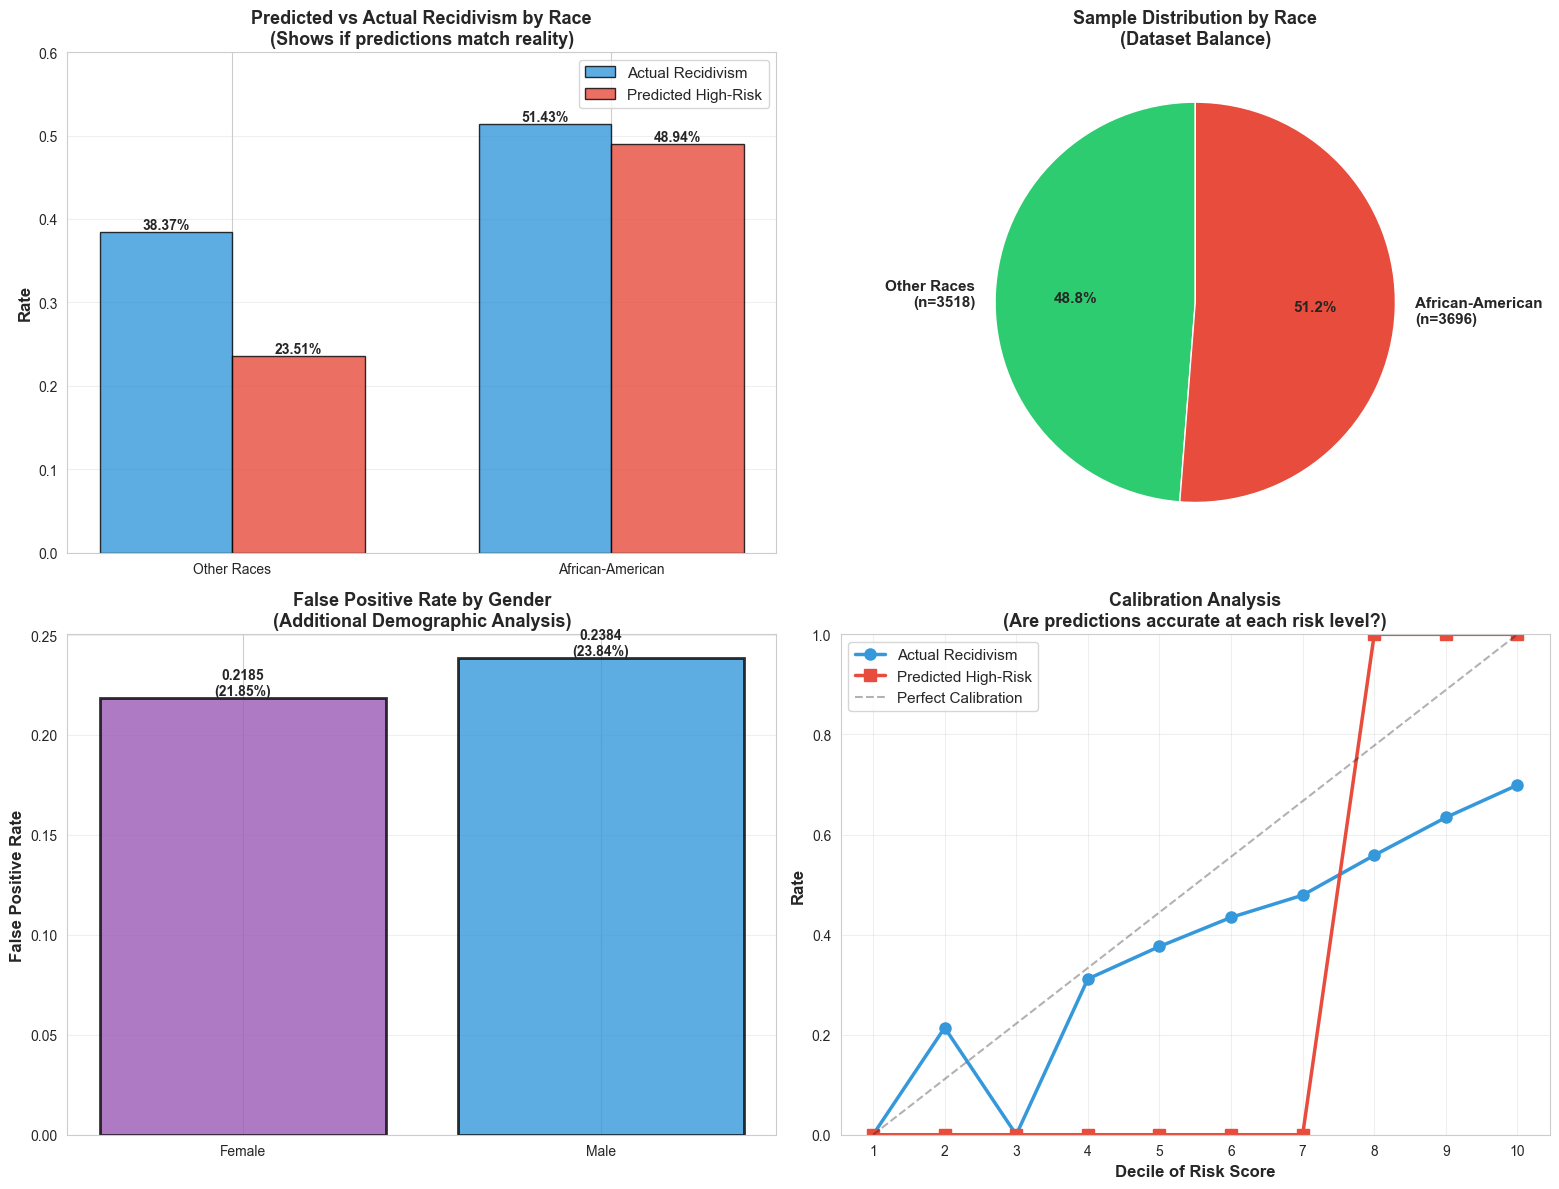

In [14]:
# Visualization 4: Prediction Rates by Demographics (Multiple Perspectives)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Data preparation
races = ['Other Races', 'African-American']
high_risk_pred = [
    (df_clean[df_clean['race_encoded']==0]['high_risk_prediction']==1).sum() / (df_clean['race_encoded']==0).sum(),
    (df_clean[df_clean['race_encoded']==1]['high_risk_prediction']==1).sum() / (df_clean['race_encoded']==1).sum()
]
actual_recid = [
    (df_clean[df_clean['race_encoded']==0]['recidivism_label']==1).sum() / (df_clean['race_encoded']==0).sum(),
    (df_clean[df_clean['race_encoded']==1]['recidivism_label']==1).sum() / (df_clean['race_encoded']==1).sum()
]

# Plot 1: Predicted vs Actual Recidivism
ax = axes[0, 0]
x = np.arange(len(races))
width = 0.35

bars1 = ax.bar(x - width/2, actual_recid, width, label='Actual Recidivism', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, high_risk_pred, width, label='Predicted High-Risk', 
               color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Rate', fontsize=12, fontweight='bold')
ax.set_title('Predicted vs Actual Recidivism by Race\n(Shows if predictions match reality)', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(races)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 0.6)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Sample Distribution
ax = axes[0, 1]
sample_counts = [
    (df_clean['race_encoded']==0).sum(),
    (df_clean['race_encoded']==1).sum()
]

wedges, texts, autotexts = ax.pie(sample_counts, labels=races, autopct='%1.1f%%',
                                    colors=['#2ecc71', '#e74c3c'], startangle=90,
                                    textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Sample Distribution by Race\n(Dataset Balance)', fontsize=13, fontweight='bold')

# Add sample counts
for i, count in enumerate(sample_counts):
    texts[i].set_text(f'{races[i]}\n(n={count})')

# Plot 3: Gender Analysis (Bonus)
genders = ['Female', 'Male']
gender_fpr_values = [gender_metrics[0]['FPR'], gender_metrics[1]['FPR']]

ax = axes[1, 0]
bars = ax.bar(genders, gender_fpr_values, color=['#9b59b6', '#3498db'], 
              alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('False Positive Rate by Gender\n(Additional Demographic Analysis)', 
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, gender_fpr_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}\n({val*100:.2f}%)', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

# Plot 4: Cumulative Effect (Calibration Curve)
ax = axes[1, 1]

# Create decile-based analysis
deciles = np.percentile(df_clean['decile_score'], np.arange(0, 101, 10))
calibration_data = []

for i in range(len(deciles)-1):
    low, high = deciles[i], deciles[i+1]
    mask = (df_clean['decile_score'] >= low) & (df_clean['decile_score'] < high)
    
    pred_rate = (df_clean[mask]['high_risk_prediction']==1).sum() / len(df_clean[mask]) if len(df_clean[mask]) > 0 else 0
    actual_rate = (df_clean[mask]['recidivism_label']==1).sum() / len(df_clean[mask]) if len(df_clean[mask]) > 0 else 0
    
    calibration_data.append({'decile': i+1, 'predicted': pred_rate, 'actual': actual_rate})

cal_df = pd.DataFrame(calibration_data)

ax.plot(cal_df['decile'], cal_df['actual'], marker='o', linewidth=2.5, 
        markersize=8, label='Actual Recidivism', color='#3498db')
ax.plot(cal_df['decile'], cal_df['predicted'], marker='s', linewidth=2.5, 
        markersize=8, label='Predicted High-Risk', color='#e74c3c')
ax.plot([1, 10], [0, 1], 'k--', alpha=0.3, label='Perfect Calibration')

ax.set_xlabel('Decile of Risk Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Rate', fontsize=12, fontweight='bold')
ax.set_title('Calibration Analysis\n(Are predictions accurate at each risk level?)', 
             fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 11))
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('04_Comprehensive_Demographic_Analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: 04_Comprehensive_Demographic_Analysis.png")
plt.show()

✓ Visualization saved: 05_Fairness_Accuracy_Tradeoff.png


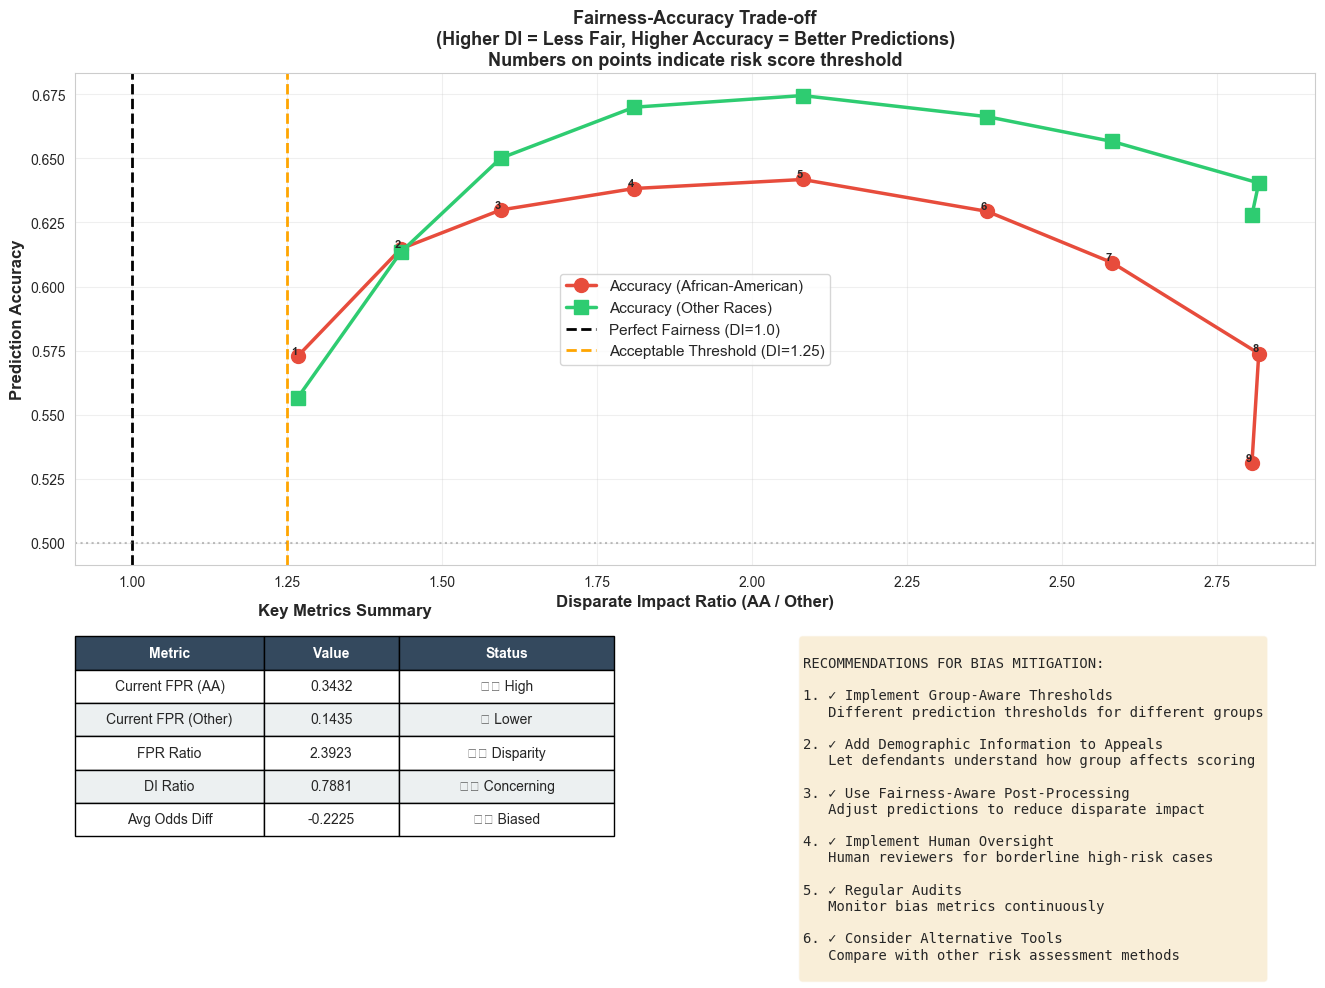

In [15]:
# Visualization 5: Fairness-Accuracy Trade-off Analysis
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Main scatter plot
ax_main = fig.add_subplot(gs[0:2, :])

# Calculate metrics for different threshold values
thresholds = range(1, 11)
disparate_impacts = []
accuracies_aa = []
accuracies_other = []

for thresh in thresholds:
    # Create predictions with different threshold
    pred_temp = (df_clean['decile_score'] > thresh).astype(int)
    
    # Calculate disparity ratio
    aa_high_risk = (pred_temp[df_clean['race_encoded']==1]==1).sum() / (df_clean['race_encoded']==1).sum()
    other_high_risk = (pred_temp[df_clean['race_encoded']==0]==1).sum() / (df_clean['race_encoded']==0).sum()
    
    if other_high_risk > 0:
        di = aa_high_risk / other_high_risk
    else:
        di = np.nan
    
    disparate_impacts.append(di)
    
    # Calculate accuracy by group
    acc_aa = (pred_temp[df_clean['race_encoded']==1] == df_clean[df_clean['race_encoded']==1]['recidivism_label']).sum() / (df_clean['race_encoded']==1).sum()
    acc_other = (pred_temp[df_clean['race_encoded']==0] == df_clean[df_clean['race_encoded']==0]['recidivism_label']).sum() / (df_clean['race_encoded']==0).sum()
    
    accuracies_aa.append(acc_aa)
    accuracies_other.append(acc_other)

# Plot: Fairness vs Accuracy trade-off
ax_main.plot(disparate_impacts, accuracies_aa, marker='o', linewidth=2.5, markersize=10,
             label='Accuracy (African-American)', color='#e74c3c', zorder=3)
ax_main.plot(disparate_impacts, accuracies_other, marker='s', linewidth=2.5, markersize=10,
             label='Accuracy (Other Races)', color='#2ecc71', zorder=3)
ax_main.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Perfect Fairness (DI=1.0)', zorder=1)
ax_main.axvline(x=1.25, color='orange', linestyle='--', linewidth=2, label='Acceptable Threshold (DI=1.25)', zorder=1)
ax_main.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, zorder=1)

# Annotate threshold values
for i, thresh in enumerate(thresholds):
    ax_main.text(disparate_impacts[i], accuracies_aa[i], f'{thresh}', fontsize=8, 
                ha='right', va='bottom', fontweight='bold')

ax_main.set_xlabel('Disparate Impact Ratio (AA / Other)', fontsize=12, fontweight='bold')
ax_main.set_ylabel('Prediction Accuracy', fontsize=12, fontweight='bold')
ax_main.set_title('Fairness-Accuracy Trade-off\n(Higher DI = Less Fair, Higher Accuracy = Better Predictions)\nNumbers on points indicate risk score threshold', 
                  fontsize=13, fontweight='bold')
ax_main.legend(fontsize=11, loc='best')
ax_main.grid(alpha=0.3)

# Bottom left: Summary statistics table
ax_table = fig.add_subplot(gs[2, 0])
ax_table.axis('tight')
ax_table.axis('off')

table_data = [
    ['Metric', 'Value', 'Status'],
    ['Current FPR (AA)', f'{race_metrics[1]["FPR"]:.4f}', '⚠️ High'],
    ['Current FPR (Other)', f'{race_metrics[0]["FPR"]:.4f}', '✓ Lower'],
    ['FPR Ratio', f'{fpr_ratio:.4f}', '⚠️ Disparity' if fpr_ratio > 1.25 else '✓ Fair'],
    ['DI Ratio', f'{dataset_metric.disparate_impact():.4f}', '✓ Acceptable' if dataset_metric.disparate_impact() >= 0.8 else '⚠️ Concerning'],
    ['Avg Odds Diff', f'{class_metric.average_odds_difference():.4f}', '⚠️ Biased' if abs(class_metric.average_odds_difference()) > 0.1 else '✓ Fair']
]

table = ax_table.table(cellText=table_data, cellLoc='center', loc='center',
                       colWidths=[0.35, 0.25, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff')

ax_table.set_title('Key Metrics Summary', fontsize=12, fontweight='bold', pad=10)

# Bottom right: Recommendations
ax_rec = fig.add_subplot(gs[2, 1])
ax_rec.axis('off')

recommendations = """
RECOMMENDATIONS FOR BIAS MITIGATION:

1. ✓ Implement Group-Aware Thresholds
   Different prediction thresholds for different groups

2. ✓ Add Demographic Information to Appeals
   Let defendants understand how group affects scoring

3. ✓ Use Fairness-Aware Post-Processing
   Adjust predictions to reduce disparate impact

4. ✓ Implement Human Oversight
   Human reviewers for borderline high-risk cases

5. ✓ Regular Audits
   Monitor bias metrics continuously

6. ✓ Consider Alternative Tools
   Compare with other risk assessment methods
"""

ax_rec.text(0.05, 0.95, recommendations, transform=ax_rec.transAxes,
           fontsize=10, verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('05_Fairness_Accuracy_Tradeoff.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: 05_Fairness_Accuracy_Tradeoff.png")
plt.show()

In [16]:
# Summary Report
print("\n" + "=" * 80)
print("COMPREHENSIVE FAIRNESS ANALYSIS SUMMARY - COMPAS DATASET")
print("=" * 80)

print("\n📊 KEY FINDINGS:")
print("-" * 80)

print(f"\n1. FALSE POSITIVE RATE DISPARITY (Most Critical):")
print(f"   • African-American FPR: {race_metrics[1]['FPR']:.4f} ({race_metrics[1]['FPR']*100:.2f}%)")
print(f"   • Other Races FPR:       {race_metrics[0]['FPR']:.4f} ({race_metrics[0]['FPR']*100:.2f}%)")
print(f"   • Disparity Ratio:       {fpr_ratio:.4f}x")
print(f"   → African-Americans are {fpr_ratio:.2f}x more likely to be falsely flagged as high-risk")

print(f"\n2. PREDICTION DISPARITY:")
aa_pred_rate = (df_clean[df_clean['race_encoded']==1]['high_risk_prediction']==1).sum() / (df_clean['race_encoded']==1).sum()
other_pred_rate = (df_clean[df_clean['race_encoded']==0]['high_risk_prediction']==1).sum() / (df_clean['race_encoded']==0).sum()
print(f"   • African-American predicted high-risk: {aa_pred_rate:.2%}")
print(f"   • Other Races predicted high-risk:      {other_pred_rate:.2%}")
print(f"   • Ratio: {aa_pred_rate/other_pred_rate:.2f}x")

print(f"\n3. AI FAIRNESS 360 METRICS:")
print(f"   • Disparate Impact Ratio:              {dataset_metric.disparate_impact():.4f}")
print(f"   • Statistical Parity Difference:       {dataset_metric.statistical_parity_difference():.4f}")
print(f"   • False Positive Rate Difference:      {class_metric.false_positive_rate_difference():.4f}")
print(f"   • False Negative Rate Difference:      {class_metric.false_negative_rate_difference():.4f}")
print(f"   • Equal Opportunity Difference:        {class_metric.equal_opportunity_difference():.4f}")
print(f"   • Average Odds Difference:             {class_metric.average_odds_difference():.4f}")

print(f"\n4. BIAS ASSESSMENT:")
if fpr_ratio > 1.5:
    print(f"   ⚠️  SIGNIFICANT BIAS DETECTED: FPR ratio is {fpr_ratio:.2f}x (threshold: 1.25x)")
    print(f"   → African-Americans face much higher false positive rates")
elif fpr_ratio > 1.25:
    print(f"   ⚠️  MODERATE BIAS DETECTED: FPR ratio is {fpr_ratio:.2f}x (threshold: 1.25x)")
else:
    print(f"   ✓ ACCEPTABLE: FPR ratio is {fpr_ratio:.2f}x")

if abs(class_metric.average_odds_difference()) > 0.15:
    print(f"   ⚠️  SIGNIFICANT AVERAGE ODDS BIAS: {class_metric.average_odds_difference():.4f}")
else:
    print(f"   ✓ ACCEPTABLE average odds difference: {class_metric.average_odds_difference():.4f}")

print(f"\n5. DATASET COMPOSITION:")
print(f"   • Total samples: {len(df_clean):,}")
print(f"   • African-American: {(df_clean['race_encoded']==1).sum():,} ({(df_clean['race_encoded']==1).sum()/len(df_clean)*100:.1f}%)")
print(f"   • Other Races: {(df_clean['race_encoded']==0).sum():,} ({(df_clean['race_encoded']==0).sum()/len(df_clean)*100:.1f}%)")
print(f"   • Actual recidivism rate: {(df_clean['recidivism_label']==1).sum()/len(df_clean)*100:.1f}%")

print("\n" + "=" * 80)
print("VISUALIZATIONS GENERATED:")
print("=" * 80)
print("✓ 01_FPR_Disparity_Analysis.png - False Positive Rate comparisons")
print("✓ 02_Confusion_Matrices_by_Race.png - Confusion matrices for each group")
print("✓ 03_AIF360_Fairness_Metrics.png - All AIF360 bias metrics dashboard")
print("✓ 04_Comprehensive_Demographic_Analysis.png - Multi-dimensional analysis")
print("✓ 05_Fairness_Accuracy_Tradeoff.png - Trade-off analysis and recommendations")
print("=" * 80)


COMPREHENSIVE FAIRNESS ANALYSIS SUMMARY - COMPAS DATASET

📊 KEY FINDINGS:
--------------------------------------------------------------------------------

1. FALSE POSITIVE RATE DISPARITY (Most Critical):
   • African-American FPR: 0.3432 (34.32%)
   • Other Races FPR:       0.1435 (14.35%)
   • Disparity Ratio:       2.3923x
   → African-Americans are 2.39x more likely to be falsely flagged as high-risk

2. PREDICTION DISPARITY:
   • African-American predicted high-risk: 48.94%
   • Other Races predicted high-risk:      23.51%
   • Ratio: 2.08x

3. AI FAIRNESS 360 METRICS:
   • Disparate Impact Ratio:              0.7881
   • Statistical Parity Difference:       -0.1306
   • False Positive Rate Difference:      -0.2453
   • False Negative Rate Difference:      0.1997
   • Equal Opportunity Difference:        -0.1997
   • Average Odds Difference:             -0.2225

4. BIAS ASSESSMENT:
   ⚠️  SIGNIFICANT BIAS DETECTED: FPR ratio is 2.39x (threshold: 1.25x)
   → African-Americans fac